In [1]:
options(warn = -1)

if (!require("AzureStor")) install.packages("AzureStor", dependencies = TRUE)
library(AzureStor)

# Connection details
account_name <- "mainprojectwis"
account_key <- "S4laxfCtH7dA87w7OGPHQVBfF39zGGeXGBDH65aYHGDJLXs4y+1UWHjLbmQoH38oehZ+1KukGIOy+AStlQdbKA=="
container_name <- "mymaincontainer"
blob_name <- "transformed-data/hourly_weather_data.csv"

# Create blob endpoint and access container
endpoint <- blob_endpoint(
  sprintf("https://%s.blob.core.windows.net/", account_name),
  key = account_key
)
container <- blob_container(endpoint, container_name)

# Download and read the CSV file
cat("Downloading blob content...\n")
temp_file <- tempfile(fileext = ".csv")
download_blob(container, blob_name, dest = temp_file)

df <- read.csv(temp_file)
cat("Data preview:\n")
print(head(df))

unlink(temp_file)  # Remove temporary file


Loading required package: AzureStor



Data preview:
  temperature dew_point_temperature station_level_pressure sea_level_pressure
1         7.2                   6.7                 1002.5             1003.3
2         6.7                   6.7                 1002.9             1003.7
3         6.1                   6.1                 1002.2             1003.0
4         7.2                   7.2                 1001.5             1002.3
5         6.1                   6.1                  999.8             1000.6
6         6.7                   6.7                  998.5              999.3
  wind_direction wind_speed precipitation relative_humidity visibility
1            200        9.8           0.3                97        0.8
2            200        5.7           0.3               100        0.8
3            200        4.1           0.0               100        0.8
4            230        3.6           0.0               100        0.4
5            190        2.6           1.3               100        0.2
6            1

In [2]:
# Set up user-specific library path
user_lib <- "~/R/library"

# Create the library directory if it doesn't exist
if (!dir.exists(user_lib)) dir.create(user_lib, recursive = TRUE)

.libPaths(c(user_lib, .libPaths()))

# Install required packages if not already installed
packages <- c("ggridges", "ggplot2", "hrbrthemes", "viridis", "GGally")
install.packages(setdiff(packages, installed.packages()[, "Package"]), lib = user_lib)


In [3]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(readr)
library(purrr)
library(tibble)
library(stringr)
library(forcats)
library(lubridate)
library(data.table)
library(ggridges)
library(viridis)
library(hrbrthemes)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: viridisLite



In [4]:
library(zoo)

# Convert 'timestamp' to Date-Time format
df <- df %>% mutate(timestamp = as.POSIXct(timestamp, format = "%Y-%m-%d %H:%M:%S"))

df <- df %>% arrange(timestamp)


# Impute missing values in 'station_level_pressure' using rolling mean
df <- df %>%
  mutate(station_level_pressure = ifelse(
    is.na(station_level_pressure),
    rollapplyr(station_level_pressure, width = 73, FUN = mean, fill = NA, partial = TRUE),
    station_level_pressure
  ))
# Extract the month as a numeric value (1 for January, 2 for February, etc.)
df$month <- month(df$timestamp)

# Convert month to a factor with the correct order
df$month <- factor(df$month, levels = 1:12, labels = month.name)

print(sapply(df, function(x) sum(is.na(x))))


Attaching package: ‘zoo’


The following objects are masked from ‘package:data.table’:

    yearmon, yearqtr


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




           temperature  dew_point_temperature station_level_pressure 
                    48                     55                   1185 
    sea_level_pressure         wind_direction             wind_speed 
                  1218                      0                     18 
         precipitation      relative_humidity             visibility 
                  9587                     55                      0 
             altimeter              timestamp                   hour 
                     0                      0                      0 
   Weather_Description              Sky_Cover                   year 
                     0                      0                      0 
                 month 
                     0 


In [7]:
df <- df %>% arrange(timestamp)
df

temperature,dew_point_temperature,station_level_pressure,sea_level_pressure,wind_direction,wind_speed,precipitation,relative_humidity,visibility,altimeter,timestamp,hour,Weather_Description,Sky_Cover,year,month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<int>,<chr>,<chr>,<int>,<chr>
7.2,6.7,1002.5,1003.3,200,9.8,0.3,97,0.8,1003.4,1990-01-01 00:00:00,0,Rain,Unknown,1990,January
6.7,6.7,1002.9,1003.7,200,5.7,0.3,100,0.8,1003.7,1990-01-01 01:00:00,1,Rain,Unknown,1990,January
6.1,6.1,1002.2,1003.0,200,4.1,0.0,100,0.8,1003.1,1990-01-01 02:00:00,2,Dense Fog,Unknown,1990,January
7.2,7.2,1001.5,1002.3,230,3.6,0.0,100,0.4,1002.4,1990-01-01 03:00:00,3,Rain,Unknown,1990,January
6.1,6.1,999.8,1000.6,190,2.6,1.3,100,0.2,1000.7,1990-01-01 04:00:00,4,Rain,Unknown,1990,January
6.7,6.7,998.5,999.3,190,2.1,2.8,100,0.8,999.3,1990-01-01 05:00:00,5,Rain,Unknown,1990,January
6.1,6.1,997.8,998.6,210,2.6,3.0,100,1.2,998.6,1990-01-01 06:00:00,6,Rain,Unknown,1990,January
6.7,6.7,997.5,998.2,240,3.1,2.3,100,2.4,998.3,1990-01-01 07:00:00,7,Rain,Unknown,1990,January
6.1,3.9,998.8,999.6,270,4.6,0.8,86,9.6,999.7,1990-01-01 08:00:00,8,Rain,Unknown,1990,January


In [6]:
summary(df)


  temperature     dew_point_temperature station_level_pressure
 Min.   :-17.80   Min.   :-30.000       Min.   : 961.9        
 1st Qu.:  5.60   1st Qu.: -1.700       1st Qu.:1011.3        
 Median : 12.80   Median :  7.200       Median :1016.1        
 Mean   : 12.65   Mean   :  6.122       Mean   :1016.1        
 3rd Qu.: 20.60   3rd Qu.: 15.000       3rd Qu.:1021.2        
 Max.   : 44.10   Max.   : 28.900       Max.   :1045.5        
 NA's   :48       NA's   :55            NA's   :1185          
 sea_level_pressure wind_direction    wind_speed     precipitation   
 Min.   : 962.7     Min.   :  0.0   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:1012.0     1st Qu.:130.0   1st Qu.: 3.100   1st Qu.: 0.000  
 Median :1016.9     Median :210.0   Median : 4.600   Median : 0.000  
 Mean   :1017.0     Mean   :202.7   Mean   : 5.008   Mean   : 0.124  
 3rd Qu.:1022.1     3rd Qu.:290.0   3rd Qu.: 6.700   3rd Qu.: 0.000  
 Max.   :1046.4     Max.   :999.0   Max.   :23.700   Max.   :73.200  
 NA's 

Picking joint bandwidth of 0.525

Picking joint bandwidth of 0.525



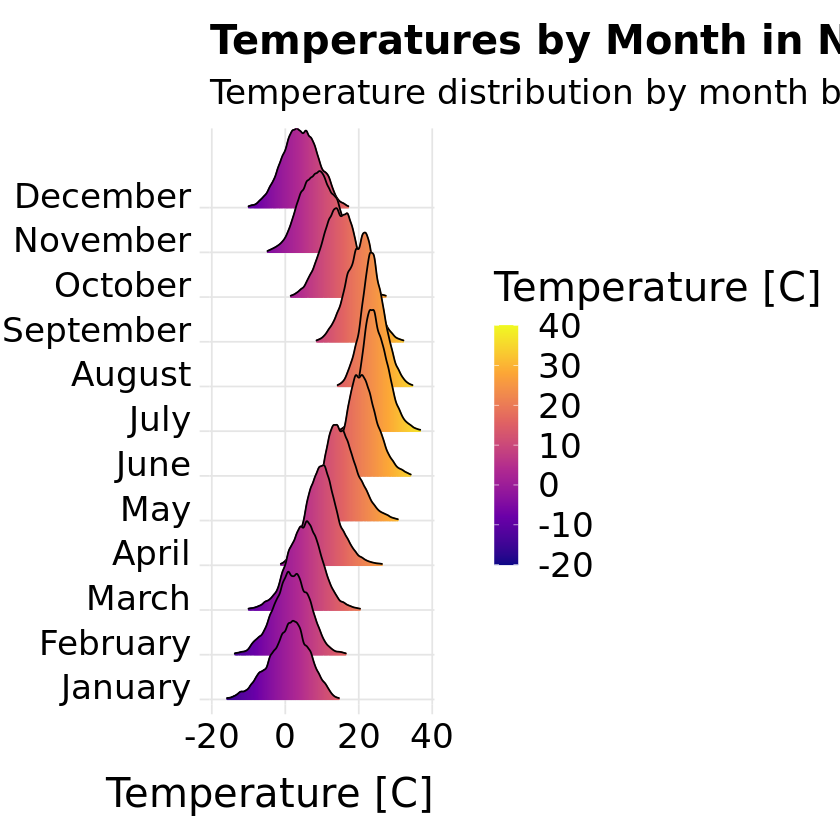

In [10]:
ggplot(df, aes(x = temperature, y = month, fill = ..x..)) +
  geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01, gradient_lwd = 1) +
  scale_x_continuous(
    limits = c(-20, 40),  
    expand = c(0.01, 0)
  ) +
  scale_y_discrete(expand = c(0.01, 0)) +
  scale_fill_viridis_c(
    name = "Temperature [C]",
    option = "C",
    limits = c(-20, 40),
      guide = guide_colorbar(
      barheight = 10,  )# Match the color gradient limits to the x-axis
  ) +
  labs(
    title = "Temperatures by Month in New York City (JFK Airport)",
    subtitle = "Temperature distribution by month between 1990 and 2023",
    x = "Temperature [C]"
  ) +
  theme_ridges(font_size = 24, grid = TRUE) +
  theme(axis.title.y = element_blank())

ggsave(
  filename = "ridgeline_plot.png",  
  plot = last_plot(),               
  width = 16,                       
  height = 8,                       
  dpi = 300                         
)



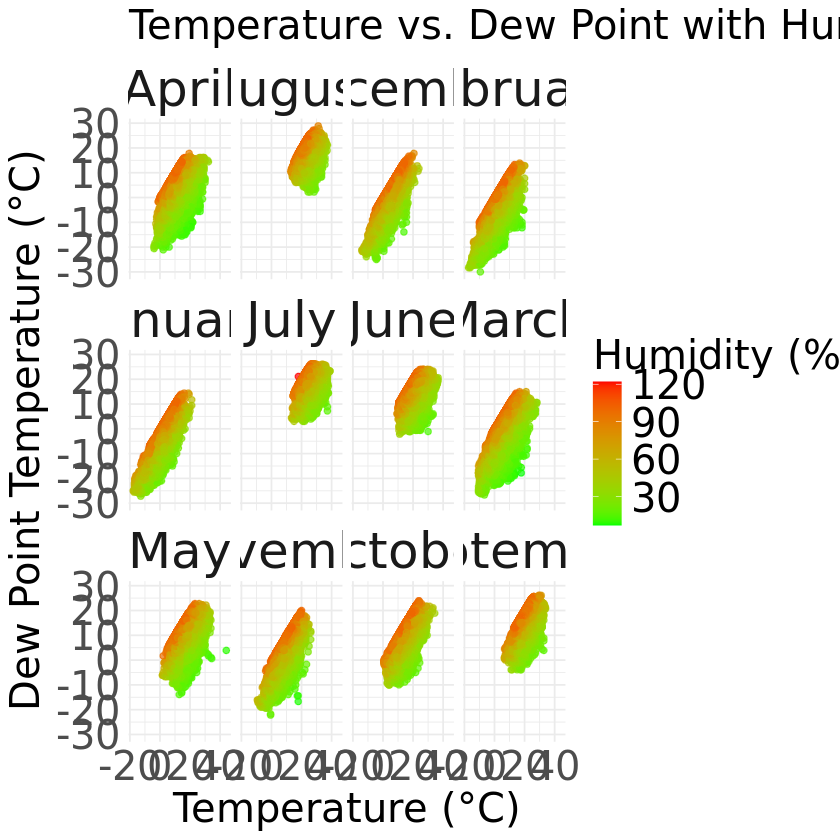

In [8]:
library(ggplot2)

ggplot(df, aes(x = temperature, y = dew_point_temperature, color = relative_humidity)) +
  geom_point(alpha = 0.7) +
  facet_wrap(~month) +
  scale_color_gradient(low = "green", high = "red") +
  labs(
    title = "Temperature vs. Dew Point with Humidity by Month",
    x = "Temperature (°C)", 
    y = "Dew Point Temperature (°C)", 
    color = "Humidity (%)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 24),  # Title font size
    axis.title.x = element_text(size = 24),  # X-axis title font size
    axis.title.y = element_text(size = 24),  # Y-axis title font size
    axis.text.x = element_text(size = 24),  # X-axis text font size
    axis.text.y = element_text(size = 24),  # Y-axis text font size
    legend.title = element_text(size = 24),  # Legend title font size
    legend.text = element_text(size = 24),
          strip.text = element_text(size = 30)     # Month names in facet_wrap
# Legend text font size
  )

# Save the plot as an image
ggsave(
  filename = "mutiple.png",  
  plot = last_plot(),               
  width = 30,                       
  height = 12,                       
  dpi = 300                         
)


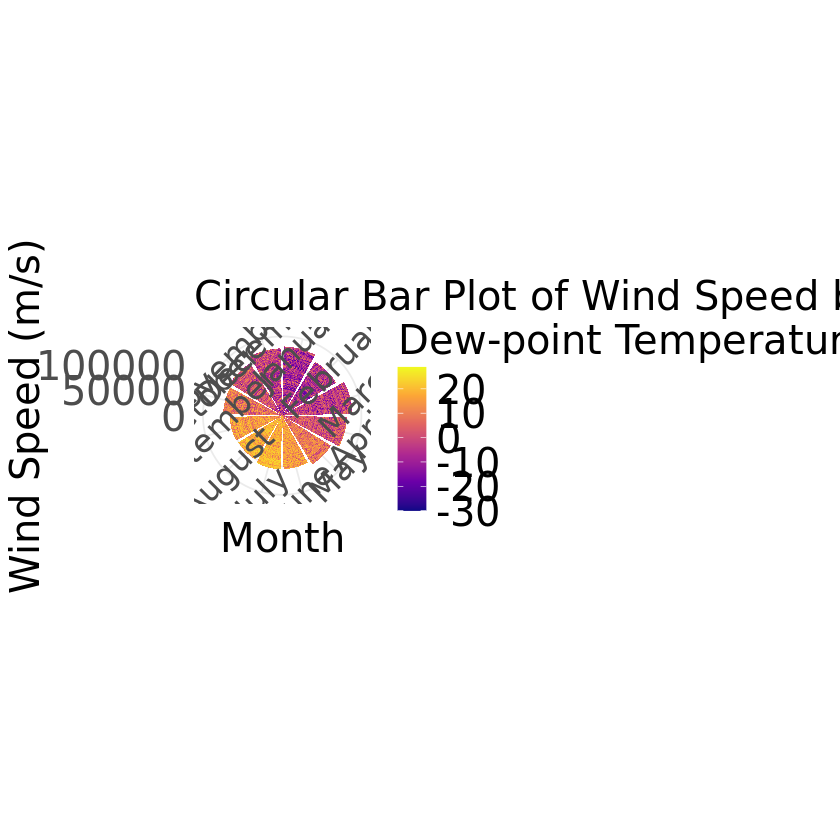

In [5]:
library(ggplot2)
library(viridis)  # For viridis color scales

# Create the circular bar plot
ggplot(df, aes(x = month, y = wind_speed, fill = dew_point_temperature),
      guide = guide_colorbar(
      barheight = 10,  )) +
  geom_bar(stat = "identity") +
  coord_polar(start = 0) +
  scale_fill_viridis_c(option = "C") +
  labs(
    title = "Circular Bar Plot of Wind Speed by Month",
    x = "Month", y = "Wind Speed (m/s)", fill = "Dew-point Temperature",
  guide = guide_colorbar(
      barheight = 12,  )) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 24),  # Title font size
    axis.title.x = element_text(size = 24),  # X-axis title font size
    axis.title.y = element_text(size = 24),  # Y-axis title font size
    axis.text.x = element_text(size = 20, angle = 45, hjust = 1),  # X-axis text font size
    axis.text.y = element_text(size = 24),  # Y-axis text font size
    legend.title = element_text(size = 24),  # Legend title font size
    legend.text = element_text(size = 24)    # Legend text font size
  )

# Save the plot as an image
ggsave(
  filename = "plot2.png",  
  plot = last_plot(),             
  width = 16,                      
  height = 8,                       
  dpi = 300                        
)


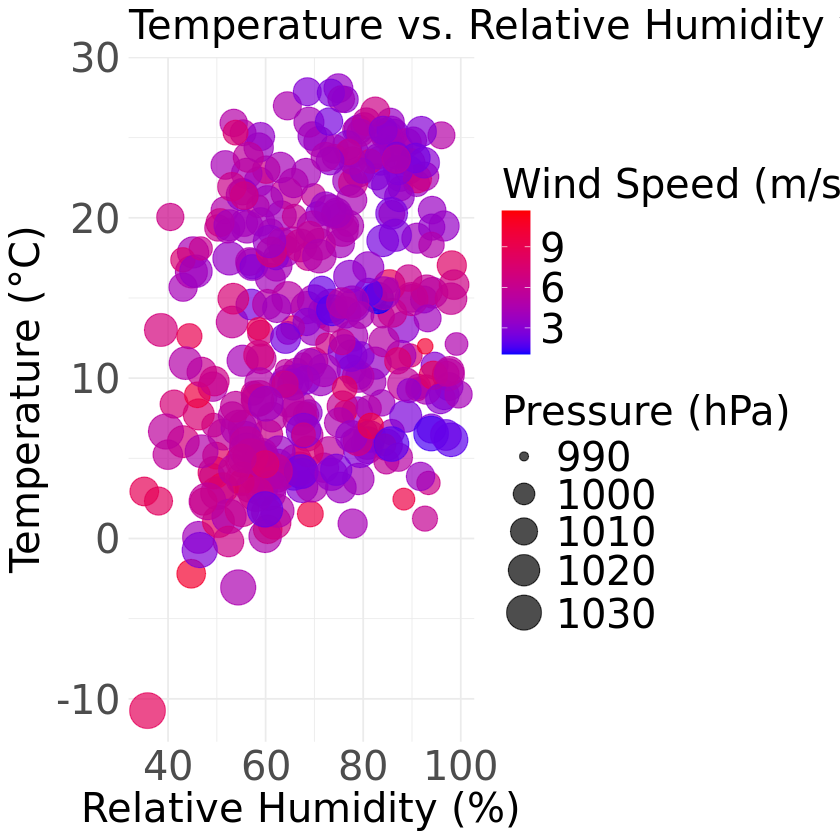

In [12]:
library(ggplot2)
library(dplyr)
library(lubridate)  

# Convert timestamp to date and filter data
data1 <- df %>%
  mutate(date = as.Date(timestamp)) %>%  # Extract only the date part
  filter(year(timestamp) == 2023) %>%   # Filter for the year 2023
  group_by(date) %>%                    # Group data by date
  summarise(
    relative_humidity = mean(relative_humidity, na.rm = TRUE),
    temperature = mean(temperature, na.rm = TRUE),
    wind_speed = mean(wind_speed, na.rm = TRUE),
    station_level_pressure = mean(station_level_pressure, na.rm = TRUE)
  )

# Plot the data with differentiated sizes for pressure
ggplot(data1, aes(
  x = relative_humidity, 
  y = temperature, 
  color = wind_speed, 
  size = station_level_pressure
)) +
  geom_point(alpha = 0.7) +
  scale_color_gradient(low = "blue", high = "red") +
  scale_size(range = c(2, 10)) +  
  labs(
    title = "Temperature vs. Relative Humidity with Wind Speed and Pressure 2023 Year",
    x = "Relative Humidity (%)",
    y = "Temperature (°C)",
    color = "Wind Speed (m/s)",
    size = "Pressure (hPa)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 24),  # Title font size
    axis.title.x = element_text(size = 24),  # X-axis title font size
    axis.title.y = element_text(size = 24),  # Y-axis title font size
    axis.text.x = element_text(size = 24),  # X-axis tick label size
    axis.text.y = element_text(size = 24),  # Y-axis tick label size
    legend.title = element_text(size = 24),  # Legend title font size
    legend.text = element_text(size = 24)   # Legend text font size
  )

# Save the plot as an image
ggsave(
  filename = "scatter_plot_with_pressure.png",
  plot = last_plot(),
  width = 16,  
  height = 8,  
  dpi = 300    
)


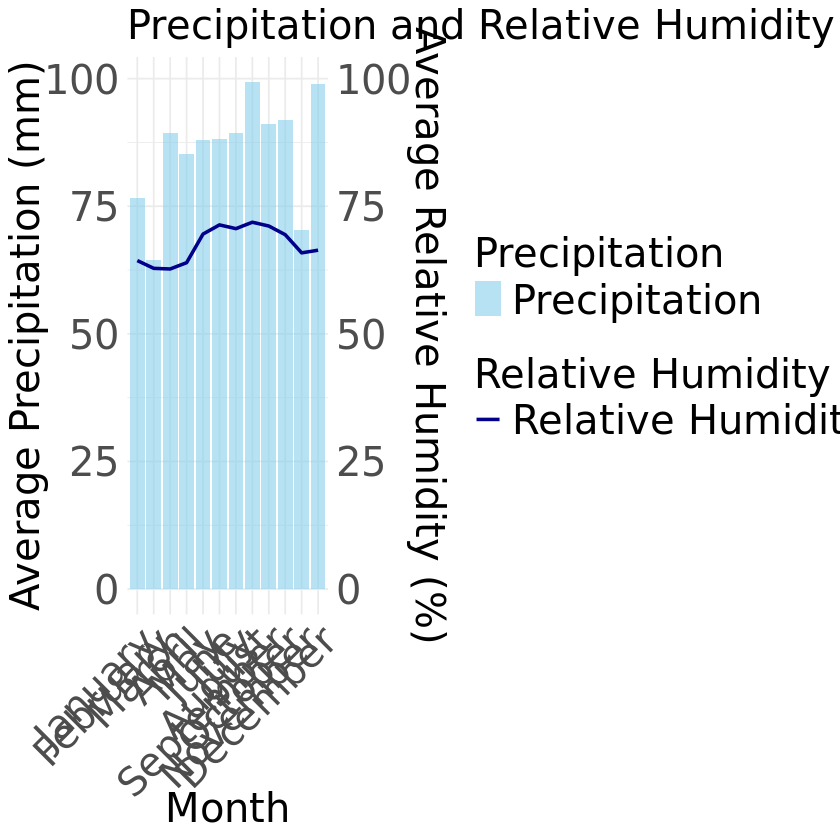

In [13]:
library(ggplot2)
library(dplyr)

rainy_summary <- df %>%
  group_by(month) %>%
  summarise(
    total_precipitation = sum(precipitation, na.rm = TRUE),  # Total precipitation for the month
    num_years = n_distinct(year),  
    avg_humidity = mean(relative_humidity, na.rm = TRUE)  # Average humidity for the month
  ) %>%
  mutate(
    avg_precipitation = total_precipitation / num_years  # Average precipitation over years
  )

# Create the combined plot
ggplot(rainy_summary, aes(x = factor(month))) +
  geom_bar(aes(y = avg_precipitation, fill = "Precipitation"), stat = "identity", alpha = 0.6) +
  geom_line(aes(y = avg_humidity , color = "Relative Humidity"), size = 1, group = 1) +
  scale_y_continuous(
    name = "Average Precipitation (mm)",
    sec.axis = sec_axis(~ ., name = "Average Relative Humidity (%)")
  ) +
  scale_fill_manual(values = "skyblue") +
  scale_color_manual(values = "darkblue") +
  labs(
    title = "Precipitation and Relative Humidity During Rain by Month",
    x = "Month",
    fill = "Precipitation",
    color = "Relative Humidity"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 24),              # Title font size
    axis.title.x = element_text(size = 24),            # X-axis title font size
    axis.title.y = element_text(size = 24),            # Y-axis title font size
    axis.text.x = element_text(size = 24, angle = 45, hjust = 1),  # X-axis tick label size
    axis.text.y = element_text(size = 24),             # Y-axis tick label size
    legend.title = element_text(size = 24),            # Legend title font size
    legend.text = element_text(size = 24)              # Legend text font size
  )

# Save the plot as an image
ggsave(
  filename = "rain.png",
  plot = last_plot(),
  width = 16,  
  height = 8,  
  dpi = 300    
)
